# Convert a Tensorflow Lite Model to OpenVINO™

> **Note:** This notebook has been moved to a new branch named "latest". [Click here](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/tflite-to-openvino/tflite-to-openvino.ipynb) to get the most updated version of the notebook. This branch is deprecated.

[TensorFlow Lite](https://www.tensorflow.org/lite/guide), often referred to as TFLite, is an open source library developed for deploying machine learning models to edge devices. 

This short tutorial shows how to convert a TensorFlow Lite [EfficientNet-Lite-B0](https://tfhub.dev/tensorflow/lite-model/efficientnet/lite0/fp32/2) image classification model to OpenVINO [Intermediate Representation](https://docs.openvino.ai/2024/documentation/openvino-ir-format/operation-sets.html) (OpenVINO IR) format, using Model Converter. After creating the OpenVINO IR, load the model in [OpenVINO Runtime](https://docs.openvino.ai/2024/openvino-workflow/running-inference.html) and do inference with a sample image.


#### Table of contents:

- [Preparation](#Preparation)
    - [Install requirements](#Install-requirements)
    - [Imports](#Imports)
- [Download TFLite model](#Download-TFLite-model)
- [Convert a Model to OpenVINO IR Format](#Convert-a-Model-to-OpenVINO-IR-Format)
- [Load model using OpenVINO TensorFlow Lite Frontend](#Load-model-using-OpenVINO-TensorFlow-Lite-Frontend)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
    - [Select inference device](#Select-inference-device)
- [Estimate Model Performance](#Estimate-Model-Performance)



## Preparation
[back to top ⬆️](#Table-of-contents:)

### Install requirements
[back to top ⬆️](#Table-of-contents:)


In [1]:
%pip install -q "openvino>=2023.1.0"
%pip install -q opencv-python requests tqdm

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
);


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Imports
[back to top ⬆️](#Table-of-contents:)


In [2]:
from pathlib import Path
import numpy as np
from PIL import Image
import openvino as ov

from notebook_utils import download_file, load_image

## Download TFLite model
[back to top ⬆️](#Table-of-contents:)


In [3]:
model_dir = Path("model")
tflite_model_path = model_dir / "efficientnet_lite0_fp32_2.tflite"

ov_model_path = tflite_model_path.with_suffix(".xml")
model_url = "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/tfLite/variations/lite0-fp32/versions/2?lite-format=tflite"

download_file(model_url, tflite_model_path.name, model_dir)

'model/efficientnet_lite0_fp32_2.tflite' already exists.


PosixPath('/home/ea/work/openvino_notebooks/notebooks/119-tflite-to-openvino/model/efficientnet_lite0_fp32_2.tflite')

## Convert a Model to OpenVINO IR Format
[back to top ⬆️](#Table-of-contents:)

To convert the TFLite model to OpenVINO IR, model conversion Python API can be used. `ov.convert_model` function accepts the path to the TFLite model and returns an OpenVINO Model class instance which represents this model. The obtained model is ready to use and to be loaded on a device using `ov.compile_model` or can be saved on a disk using `ov.save_model` function, reducing loading time for next running. By default, model weights are compressed to FP16 during serialization by `ov.save_model`.
For more information about model conversion, see this [page](https://docs.openvino.ai/2024/openvino-workflow/model-preparation.html). For TensorFlow Lite models support, refer to this [tutorial](https://docs.openvino.ai/2024/openvino-workflow/model-preparation/convert-model-tensorflow-lite.html).

In [4]:
ov_model = ov.convert_model(tflite_model_path)
ov.save_model(ov_model, ov_model_path)
print(f"Model {tflite_model_path} successfully converted and saved to {ov_model_path}")

Model model/efficientnet_lite0_fp32_2.tflite successfully converted and saved to model/efficientnet_lite0_fp32_2.xml


## Load model using OpenVINO TensorFlow Lite Frontend
[back to top ⬆️](#Table-of-contents:)

TensorFlow Lite models are supported via `FrontEnd` API. You may skip conversion to IR and read models directly by OpenVINO runtime API. For more examples supported formats reading via Frontend API, please look this [tutorial](../002-openvino-api).

In [5]:
core = ov.Core()

ov_model = core.read_model(tflite_model_path)

## Run OpenVINO model inference
[back to top ⬆️](#Table-of-contents:)

We can find information about model input preprocessing in its [description](https://tfhub.dev/tensorflow/lite-model/efficientnet/lite0/fp32/2) on [TensorFlow Hub](https://tfhub.dev/).

In [6]:
image = load_image("https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bricks.png")
# load_image reads the image in BGR format, [:,:,::-1] reshape transfroms it to RGB
image = Image.fromarray(image[:,:,::-1])
resized_image = image.resize((224, 224))
input_tensor = np.expand_dims((np.array(resized_image).astype(np.float32) - 127) / 128, 0)

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [7]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [8]:
compiled_model = core.compile_model(ov_model, device.value)
predicted_scores = compiled_model(input_tensor)[0]

'imagenet_2012.txt' already exists.


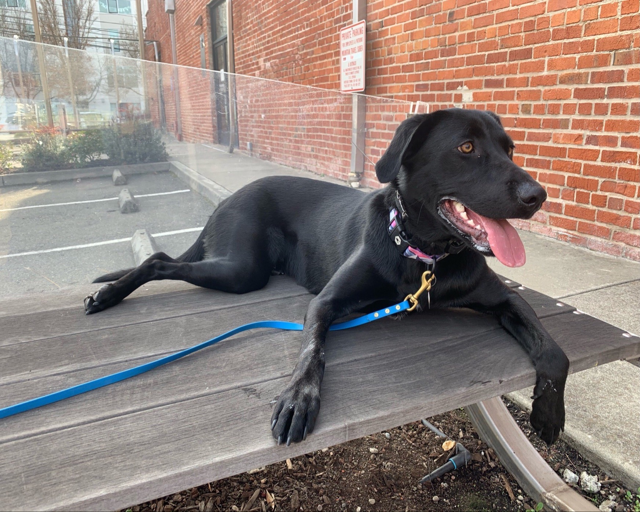

Predicted label: n02109047 Great Dane with probability 0.715318


In [9]:
imagenet_classes_file_path = download_file("https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/datasets/imagenet/imagenet_2012.txt")
imagenet_classes = open(imagenet_classes_file_path).read().splitlines()

top1_predicted_cls_id = np.argmax(predicted_scores)
top1_predicted_score = predicted_scores[0][top1_predicted_cls_id]
predicted_label = imagenet_classes[top1_predicted_cls_id]

display(image.resize((640, 512)))
print(f"Predicted label: {predicted_label} with probability {top1_predicted_score :2f}")

## Estimate Model Performance
[back to top ⬆️](#Table-of-contents:)
[Benchmark Tool](https://docs.openvino.ai/2024/learn-openvino/openvino-samples/benchmark-tool.html) is used to measure the inference performance of the  model on CPU and GPU.

> **NOTE**: For more accurate performance, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m model.xml -d CPU` to benchmark async inference on CPU for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

In [ ]:
print(f"Benchmark model inference on {device.value}")
!benchmark_app -m $ov_model_path -d $device.value -t 15